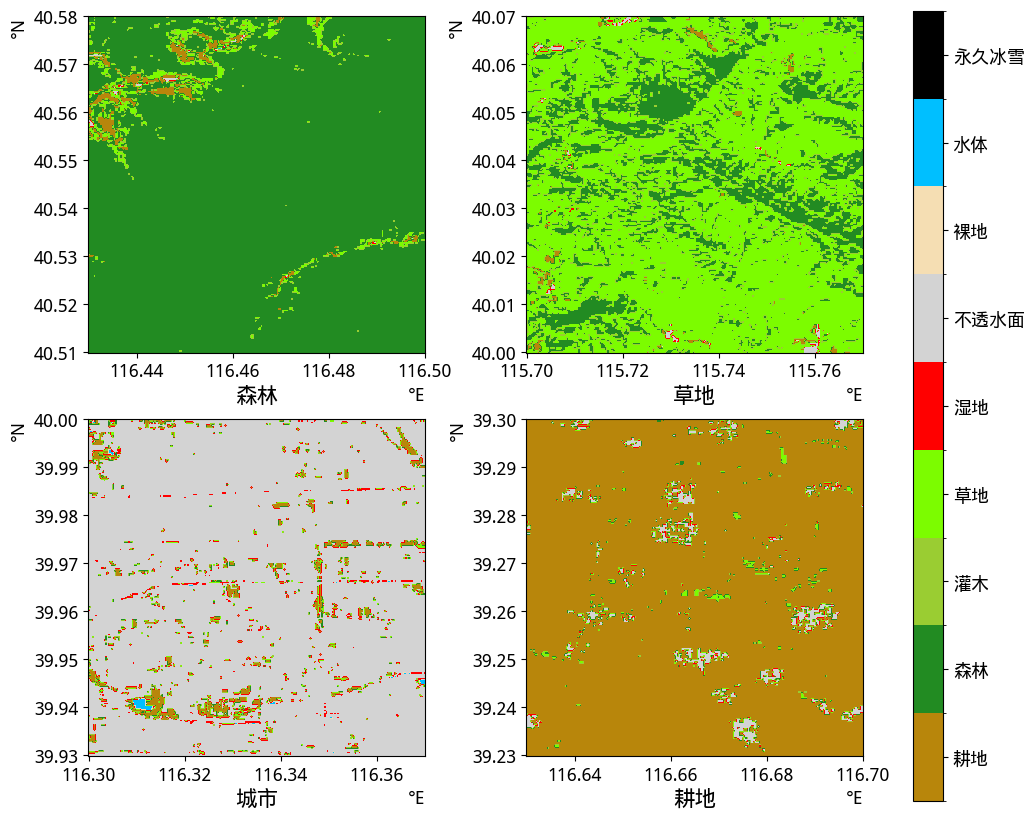

In [8]:
from tifffile import TiffFile
from matplotlib.axes import Axes
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
from functions import find_files, region, lcs

# 显示中文
def get_font_name(index=0):
    with os.popen('fc-list :lang=zh') as f:
        fonts = f.readlines()
        font_name = fonts[index].split(": ")[1].split(",")[0]
        return font_name
plt.rcParams["font.sans-serif"] = get_font_name()
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 16

class Landcover(object):
    @classmethod
    def init(cls) -> None:
        up = find_files("GLC_FCS30_2020_E115N45.tif")[0]
        down = find_files("GLC_FCS30_2020_E115N40.tif")[0]
        with TiffFile(up) as i1:
            with TiffFile(down) as i2:
                cls.data = np.vstack((i1.pages[0].asarray(), i2.pages[0].asarray()))
                _, _, _, cls.left, cls.top, _ = i1.pages[0].tags.get('ModelTiepointTag').value
                cls.dx, cls.dy, _ = i1.pages[0].tags.get('ModelPixelScaleTag').value

    df = pd.DataFrame(columns=("lc", "color"))
    df["lc"] = ("耕地", "森林", "灌木", "草地", "湿地", "不透水面", "裸地", "水体", "永久冰雪")
    df["color"] = ("darkgoldenrod","forestgreen", "yellowgreen", "lawngreen", "red", "lightgrey", "wheat", "deepskyblue", "black")
    
    cmap = ListedColormap(df["color"])
    boundaries = [i + 0.5 for i in df.index]
    norm = BoundaryNorm([boundaries[0]-1] + boundaries, len(df))
    
    @classmethod
    def find(cls, lon, lat):
        if not hasattr(cls, "data"):
            cls.init()
        i = (cls.top - lat) / cls.dy
        j = (lon - cls.left) / cls.dx
        row, col = np.uint32(i), np.uint32(j)
        return cls.data[row, col]
    
    @classmethod
    def sample(cls, lc, resolution=30e-5):
        top, left, bottom, right = region[lc]
        lon = np.arange(left, right, resolution)
        lat = np.arange(bottom, top, resolution)
        right, top = lon[-1], lat[-1]
        lon, lat = np.meshgrid(lon, lat)
        data = cls.find(lon, lat)
        dc = resolution / 2
        extent = (left-dc, right+dc, bottom-dc, top+dc)
        return data, extent
    
    @classmethod
    def mapColor(cls, data):
        data[(data >= 10) & (data <= 20)] = cls.df[cls.df["lc"] == "耕地"].index
        data[(data >= 50) & (data <= 90)] = cls.df[cls.df["lc"] == "森林"].index
        data[(data >= 120) & (data < 130)] = cls.df[cls.df["lc"] == "灌木"].index
        data[(data == 130)] = cls.df[cls.df["lc"] == "草地"].index
        data[(data == 180)] = cls.df[cls.df["lc"] == "湿地"].index
        data[(data == 190)] = cls.df[cls.df["lc"] == "不透水面"].index
        data[((data >= 140) & (data < 160)) | ((data >= 200) & (data < 210))] = cls.df[cls.df["lc"] == "裸地"].index
        data[(data == 210)] = cls.df[cls.df["lc"] == "水体"].index
        data[(data == 220)] = cls.df[cls.df["lc"] == "永久冰雪"].index

    @classmethod
    def imshow(cls, ax, lc, ytitle=-0.17):
        data, extent = cls.sample(lc)
        cls.mapColor(data)
        img = ax.imshow(data, extent=extent, cmap=cls.cmap, norm=cls.norm, origin="lower")
        ax.set_xlabel("°E", loc="right")
        ax.set_ylabel("°N", loc="top")
        ax.ticklabel_format(useOffset=False, style="plain")
        ax.set_title(lcs[lc], y=ytitle)
        return img


def display_landcover():
    plt.rcParams.update({"font.size": 13})
    fig, axes = plt.subplots(2,2,figsize=(10,10))
    first_time = True
    for ax, lc in zip(axes.ravel(), lcs.keys()):
        img = Landcover.imshow(ax, lc)
        if first_time:
            fig.colorbar(img, cax=fig.add_axes([0.95,0.08,0.03,0.79]), ticks=list(Landcover.df.index)).set_ticklabels(Landcover.df["lc"])
            first_time = False
    plt.subplots_adjust(wspace=0.3, hspace=0.1)
    plt.show()

display_landcover()

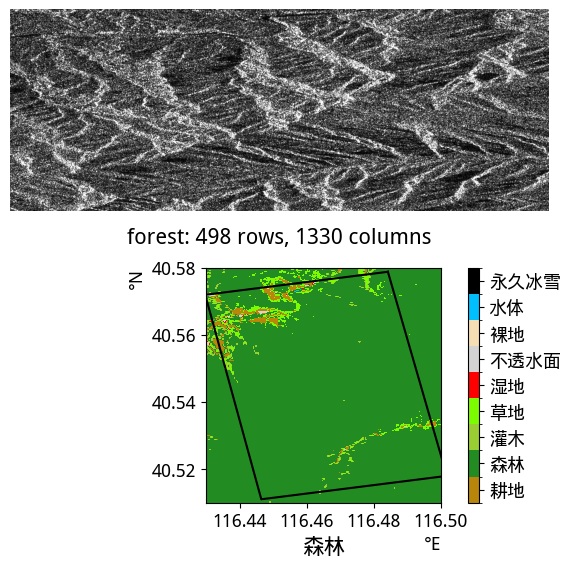

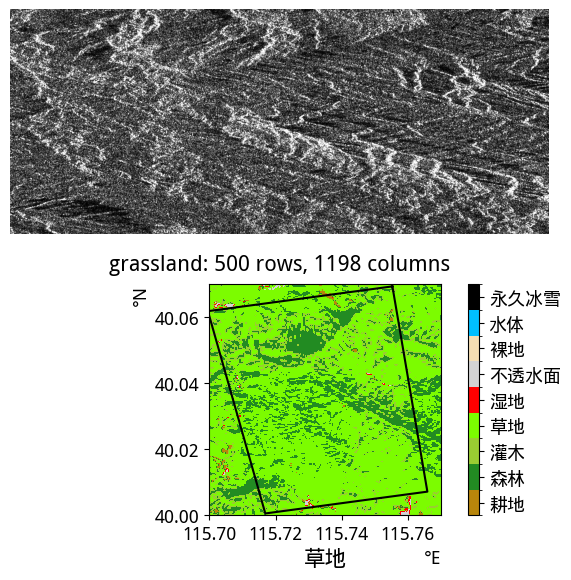

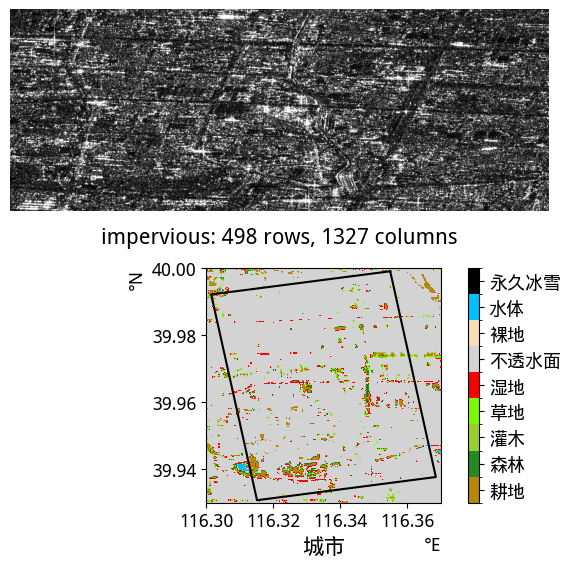

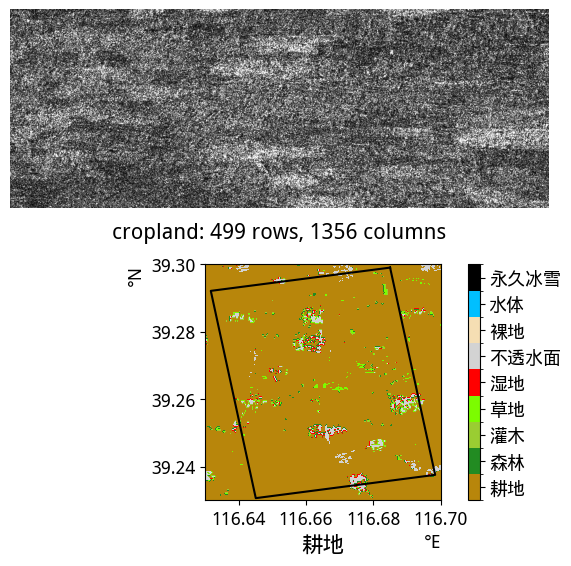

In [10]:
from functions import swath
from s1 import Swath
from multiprocessing import Pool


def display_s1(axes, lc, s1, content):
    axes[0].imshow(s1, origin="lower", cmap="gray")
    axes[0].set_axis_off()
    axes[0].set_title(f"{lc}: {s1.shape[0]} rows, {s1.shape[1]} columns", y=-0.2)

    img = Landcover.imshow(axes[1], lc, -0.25)
    axes[1].plot(content[0], content[1], c='k')
    top, left, bottom, right = region[lc]
    axes[1].set_xlim(left, right)
    axes[1].set_ylim(bottom, top)
    fig.colorbar(img, ax=axes[1], ticks=list(Landcover.df.index)).set_ticklabels(Landcover.df["lc"])

def map_s1(s1):
    s1 = np.abs(s1)
    p95 = np.nanpercentile(s1, 95)
    p5 = np.nanpercentile(s1, 5)
    s1[s1 > p95] = p95
    s1[s1 < p5] = p5
    return s1

def sample_s1(params):
    lc, swt = params
    top, left, bottom, right = region[lc]
    img = Swath(find_files("20*")[0], swt)
    data, content = img.geolocate(top, left, bottom, right)
    return lc, map_s1(data), content

p = Pool()
res = p.map(sample_s1, swath.items())
for data in res:
    plt.rcParams.update({"font.size": 13})
    fig, axes = plt.subplots(2,1, figsize=(6, 6))
    display_s1(axes, data[0], data[1], data[2])
    plt.tight_layout()
    plt.show()

In [3]:
from functions import dump_pkls
from os.path import basename


def lc_save(params):
    path, lc, swt = params
    top, left, bottom, right = region[lc]
    data = Swath(path, swt).geolocate(top, left, bottom, right)[0]
    dump_pkls(lc, basename(path), data)

def error_callback(e):
    print(e)

# 读取Sentinel-1数据疑似有点io密集，多进程的速度没有预期那么高
p = Pool()
for lc, swt in swath.items():
    p.map(lc_save, [(path, lc, swt) for path in find_files("20*")])